# SingleCell Data Analysis on the CPU
**Author:** [Severin Dicks](https://github.com/Intron7) (IBSM Freiburg)

To run this notebook please make sure you have a working enviroment with all nessaray dependencies. Run the data_downloader notebook first to create the AnnData object we are working with. In this example workflow we'll be looking at a dataset of ca. 90000 cells from [Quin et al., Cell Research 2020](https://www.nature.com/articles/s41422-020-0355-0).

In [1]:
import numpy as np
import scanpy as sc
import anndata

import time


import matplotlib.pyplot as plt
from matplotlib import rcParams

sc.set_figure_params(dpi= 80, dpi_save = 300)
rcParams['figure.figsize'] = 5,5

sc._settings.ScanpyConfig.n_jobs = 60

## Load and Prepare Data

We load the sparse count matrix from an `h5ad` file using Scanpy. 

In [2]:
data_load_start = time.time()

In [3]:
%%time
adata=sc.read("h5/adata.raw.h5ad")

CPU times: user 2.38 s, sys: 293 ms, total: 2.67 s
Wall time: 2.72 s


In [4]:
data_load_time = time.time()
print("Total data load and format time: %s" % (data_load_time-data_load_start))

Total data load and format time: 2.7350776195526123


## Preprocessing

In [5]:
preprocess_start = time.time()

### Quality Control

We perform a basic qulitiy control and plot the results

Some genes will now have zero expression in all cells. We filter out such genes.

In [6]:
%%time
adata.var['MT'] = adata.var_names.str.startswith('MT-') 

CPU times: user 5.14 ms, sys: 1.31 ms, total: 6.45 ms
Wall time: 6.3 ms


In [7]:
%%time
adata.var['RIBO'] = adata.var_names.str.startswith('RPS') 


CPU times: user 5.03 ms, sys: 92 µs, total: 5.12 ms
Wall time: 5.16 ms


In [8]:
%%time
sc.pp.calculate_qc_metrics(adata, qc_vars=['MT','RIBO'], percent_top=None, log1p=False, inplace=True)

CPU times: user 1.52 s, sys: 46.1 ms, total: 1.56 s
Wall time: 1.57 s


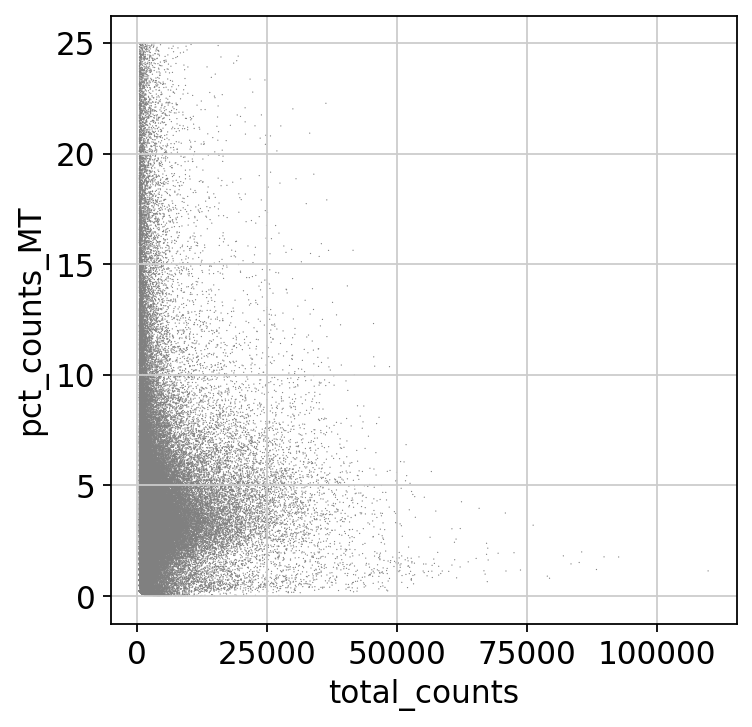

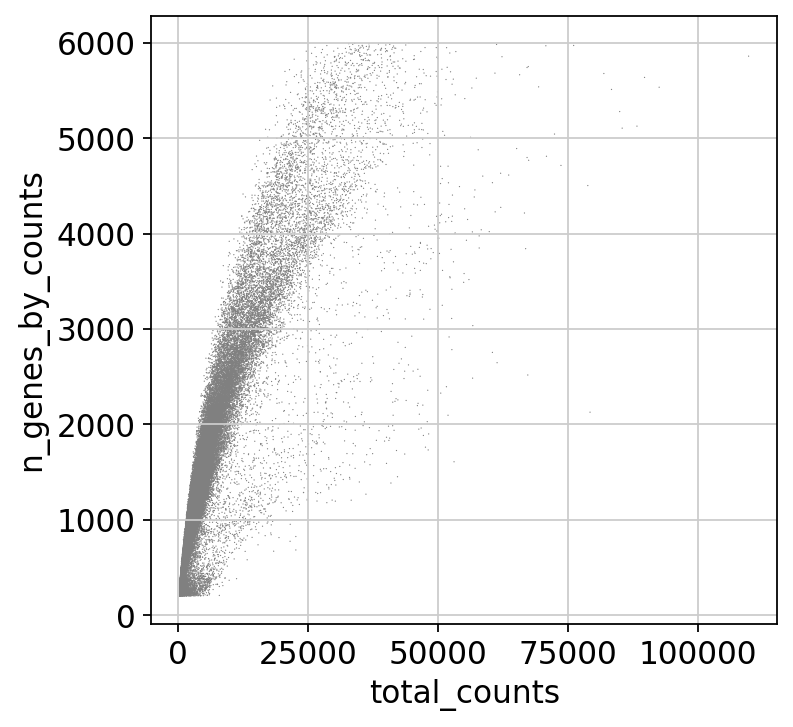

In [9]:
sc.pl.scatter(adata, x='total_counts', y='pct_counts_MT')
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

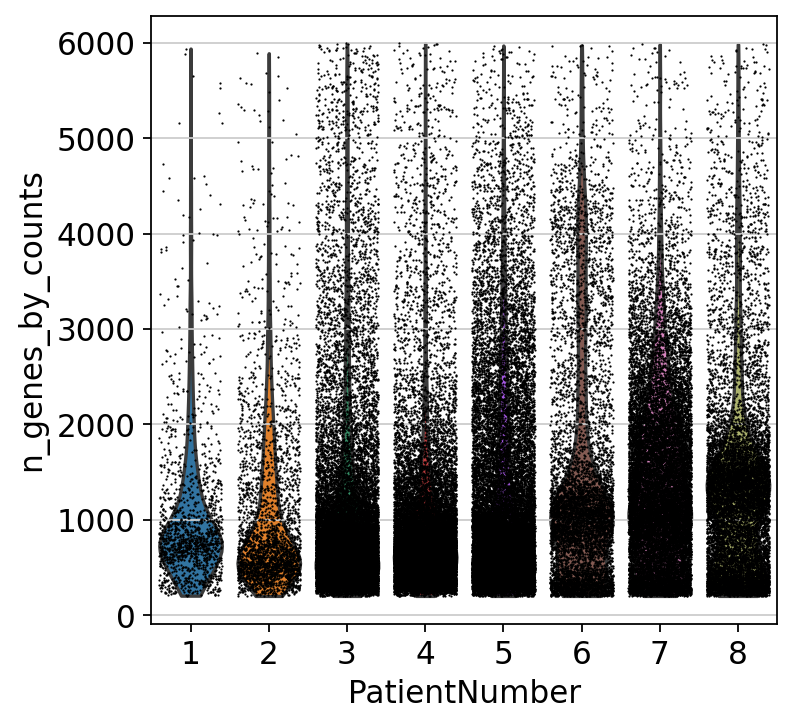

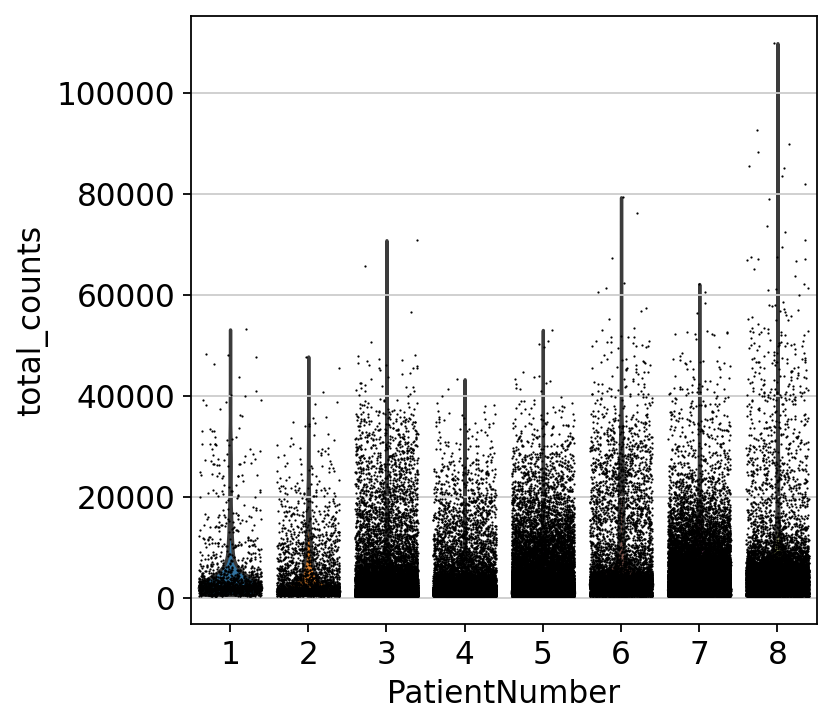

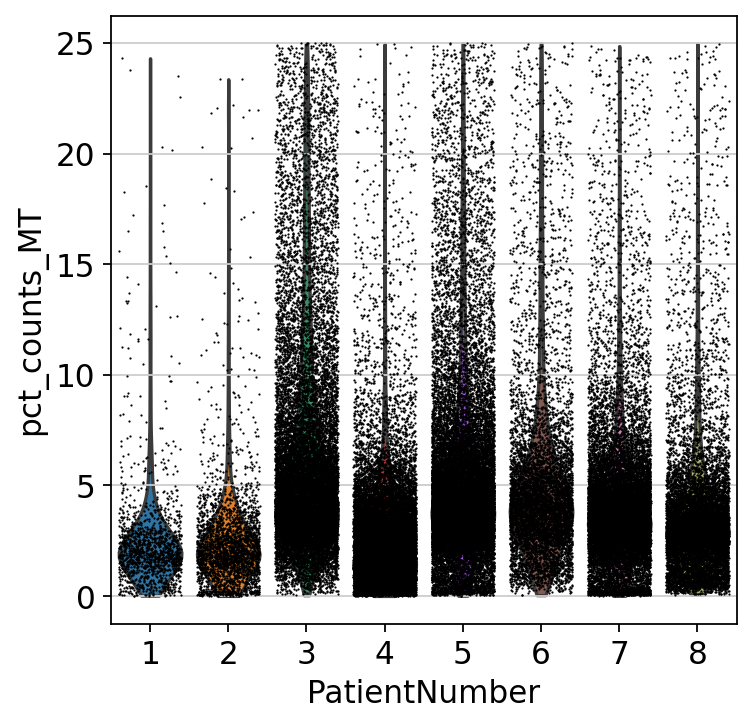

In [10]:
sc.pl.violin(adata, 'n_genes_by_counts',jitter=0.4, groupby="PatientNumber")
sc.pl.violin(adata, 'total_counts',jitter=0.4, groupby="PatientNumber")
sc.pl.violin(adata, 'pct_counts_MT',jitter=0.4, groupby="PatientNumber")


We store the raw expression counts in the `.layer["counts"]`

### Filter

We filter the count matrix to remove cells with an extreme number of genes expressed.

In [12]:
%%time
adata = adata[adata.obs.n_genes_by_counts < 5000, :]
adata.shape

CPU times: user 7.95 ms, sys: 2.01 ms, total: 9.96 ms
Wall time: 9.58 ms


(92666, 33694)

In [13]:
adata = adata[adata.obs.pct_counts_MT < 20, :]
adata.shape

(91180, 33694)

Some genes will now have zero expression in all cells. We filter out such genes.

In [14]:
%%time
sc.pp.filter_genes(adata, min_cells=3)

/home/sedi10/conda/envs/rapids-22.12/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number


CPU times: user 788 ms, sys: 396 ms, total: 1.18 s
Wall time: 1.19 s


In [15]:
adata.layers["counts"] = adata.X.copy()

In [16]:
adata.shape

(91180, 25365)

### Normalize

We normalize the count matrix so that the total counts in each cell sum to 1e4.

In [17]:
%%time
sc.pp.normalize_total(adata,target_sum=1e4)

CPU times: user 300 ms, sys: 35.4 ms, total: 335 ms
Wall time: 336 ms


Next, we log transform the count matrix.

In [18]:
%%time
sc.pp.log1p(adata)

CPU times: user 935 ms, sys: 797 µs, total: 936 ms
Wall time: 937 ms


### Select Most Variable Genes

We will now select the most variable genes in the dataset.

In [19]:
%%time
sc.pp.highly_variable_genes(adata,flavor = "seurat_v3",n_top_genes=5000,batch_key="PatientNumber",layer = "counts")

CPU times: user 3.34 s, sys: 3.06 s, total: 6.4 s
Wall time: 3.59 s


Set the `.raw` attribute of the AnnData object to the normalized and logarithmized raw gene expression for later use

In [20]:
%%time
adata.raw = adata

CPU times: user 56.9 ms, sys: 42.2 ms, total: 99.2 ms
Wall time: 98 ms


Restrict adata to only the highly variable genes

In [21]:
%%time
adata = adata[:, adata.var.highly_variable]

CPU times: user 56.1 ms, sys: 54.3 ms, total: 110 ms
Wall time: 110 ms


In [22]:
adata.shape

(91180, 5000)

Next we regess out effects of counts per cell and the mitochondrial content of the cells. 

In [23]:
%%time
sc.pp.regress_out(adata,keys=["total_counts", "pct_counts_MT"])

CPU times: user 7.79 s, sys: 6 s, total: 13.8 s
Wall time: 5min 46s


### Scale

Finally, we scale the count matrix to obtain a z-score and apply a cutoff value of 10 standard deviations, obtaining the preprocessed count matrix.

In [24]:
%%time
sc.pp.scale(adata, max_value=10)

CPU times: user 1.44 s, sys: 151 ms, total: 1.59 s
Wall time: 1.59 s


We store the preprocessed count matrix as an AnnData object, which is currently in host memory. We also add the expression levels of the marker genes as observations to the annData object.

In [25]:
preprocess_time = time.time()
print("Total Preprocessing time: %s" % (preprocess_time-preprocess_start))

Total Preprocessing time: 357.8362364768982


## Clustering and Visulization

### Principal component analysis

We use PCA to reduce the dimensionality of the matrix to its top 100 principal components. 

In [26]:
%%time
sc.tl.pca(adata, n_comps = 100)

CPU times: user 31min, sys: 47min 20s, total: 1h 18min 20s
Wall time: 46 s


We can use scanpy `pca_variance_ratio` plot to inspect the contribution of single PCs to the total variance in the data.

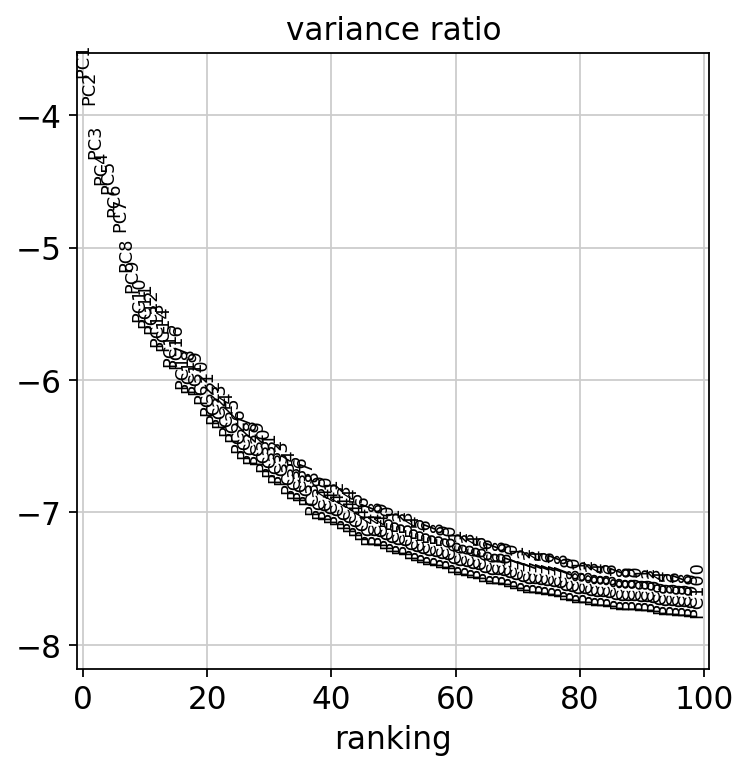

In [27]:
sc.pl.pca_variance_ratio(adata, log=True,n_pcs=100)

### Computing the neighborhood graph and UMAP

Next we compute the neighborhood graph and UMAP

In [28]:
%%time
sc.external.pp.harmony_integrate(adata,key="PatientNumber")

2023-01-11 13:38:59,129 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2023-01-11 13:40:13,484 - harmonypy - INFO - sklearn.KMeans initialization complete.
2023-01-11 13:40:13,930 - harmonypy - INFO - Iteration 1 of 10
2023-01-11 13:40:45,236 - harmonypy - INFO - Iteration 2 of 10
2023-01-11 13:41:16,966 - harmonypy - INFO - Iteration 3 of 10
2023-01-11 13:41:52,353 - harmonypy - INFO - Iteration 4 of 10
2023-01-11 13:42:26,619 - harmonypy - INFO - Iteration 5 of 10
2023-01-11 13:42:54,744 - harmonypy - INFO - Iteration 6 of 10
2023-01-11 13:43:25,039 - harmonypy - INFO - Iteration 7 of 10
2023-01-11 13:43:47,319 - harmonypy - INFO - Iteration 8 of 10
2023-01-11 13:44:13,945 - harmonypy - INFO - Converged after 8 iterations


CPU times: user 1h 18min 52s, sys: 3h 44min 34s, total: 5h 3min 26s
Wall time: 5min 15s


In [29]:
%%time
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=40)

CPU times: user 1min 9s, sys: 3min 39s, total: 4min 48s
Wall time: 22 s


In [30]:
%%time
sc.tl.umap(adata)

CPU times: user 4min 47s, sys: 9min, total: 13min 48s
Wall time: 54.9 s


### Clustering
We cluster the cells with the Leiden and Louvain algorithm

In [31]:
%%time
sc.tl.louvain(adata)

CPU times: user 12.9 s, sys: 99.4 ms, total: 13 s
Wall time: 13 s


In [32]:
%%time
sc.tl.leiden(adata)

CPU times: user 13.9 s, sys: 114 ms, total: 14 s
Wall time: 14.1 s


/home/sedi10/conda/envs/rapids-22.12/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/sedi10/conda/envs/rapids-22.12/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


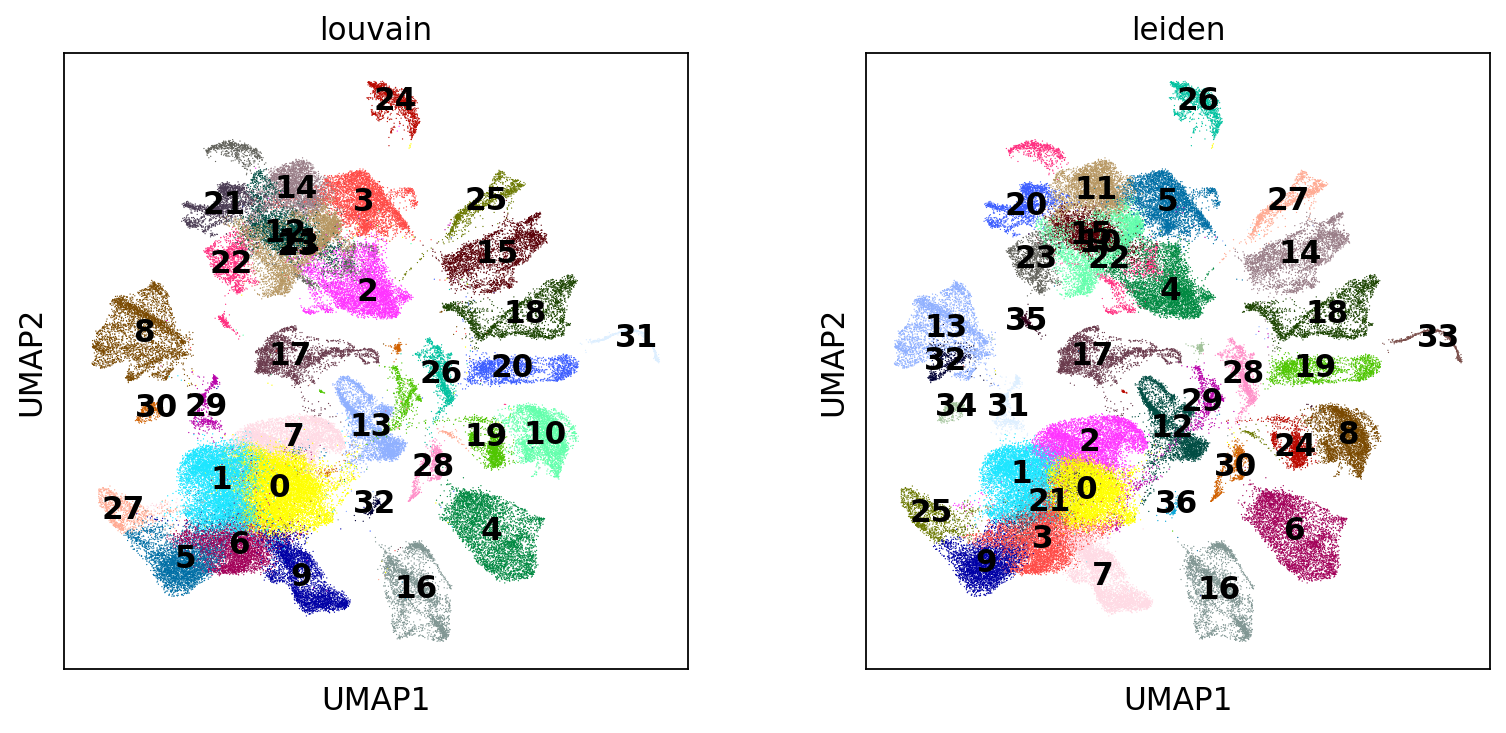

CPU times: user 702 ms, sys: 170 ms, total: 872 ms
Wall time: 700 ms


In [33]:
%%time
sc.pl.umap(adata, color=["louvain","leiden"],legend_loc = 'on data')

/home/sedi10/conda/envs/rapids-22.12/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/sedi10/conda/envs/rapids-22.12/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


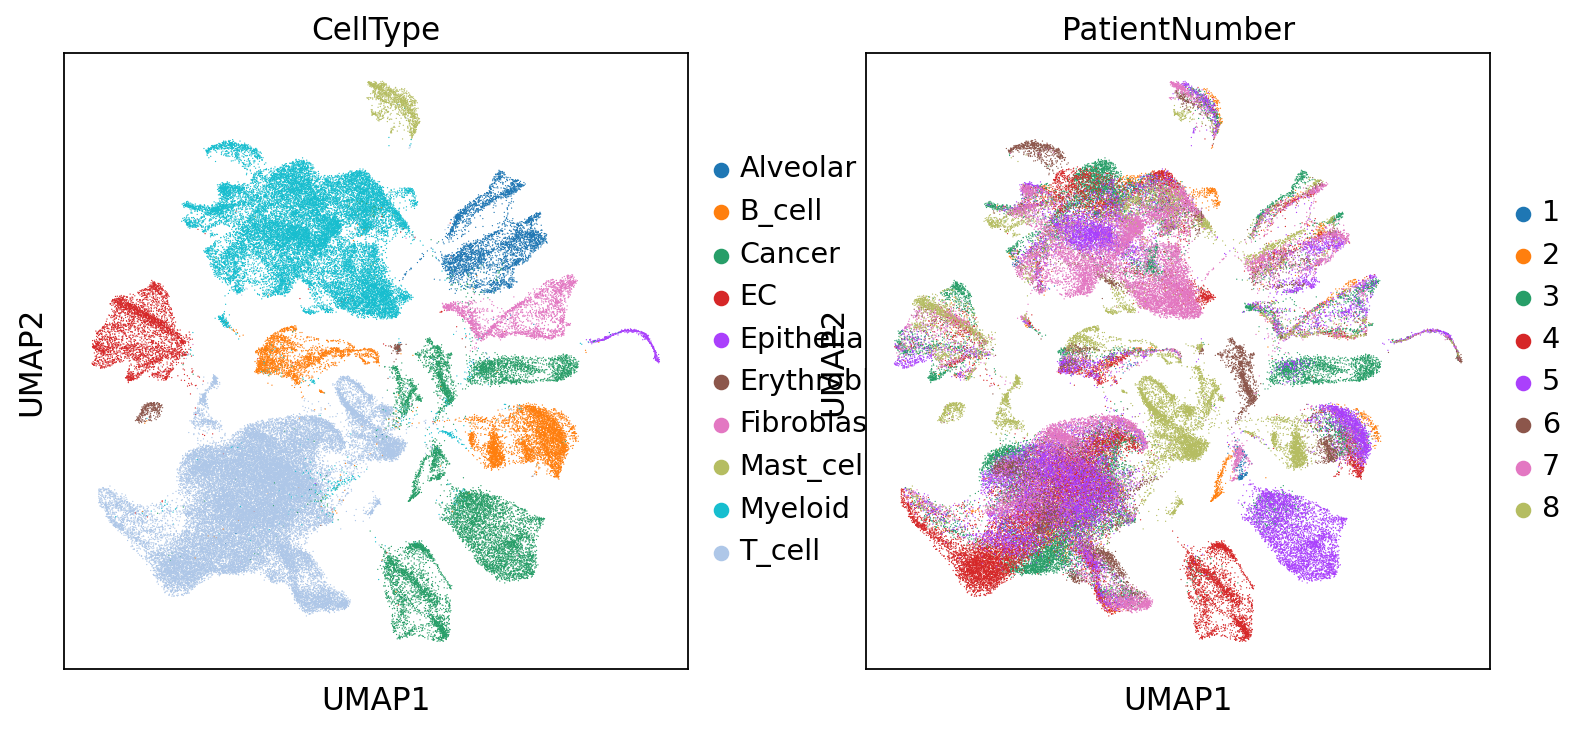

In [34]:
sc.pl.umap(adata, color= ["CellType", "PatientNumber"])

In [35]:
%%time
sc.tl.embedding_density(adata, groupby="PatientNumber")

CPU times: user 17.1 s, sys: 2.25 ms, total: 17.1 s
Wall time: 17.1 s


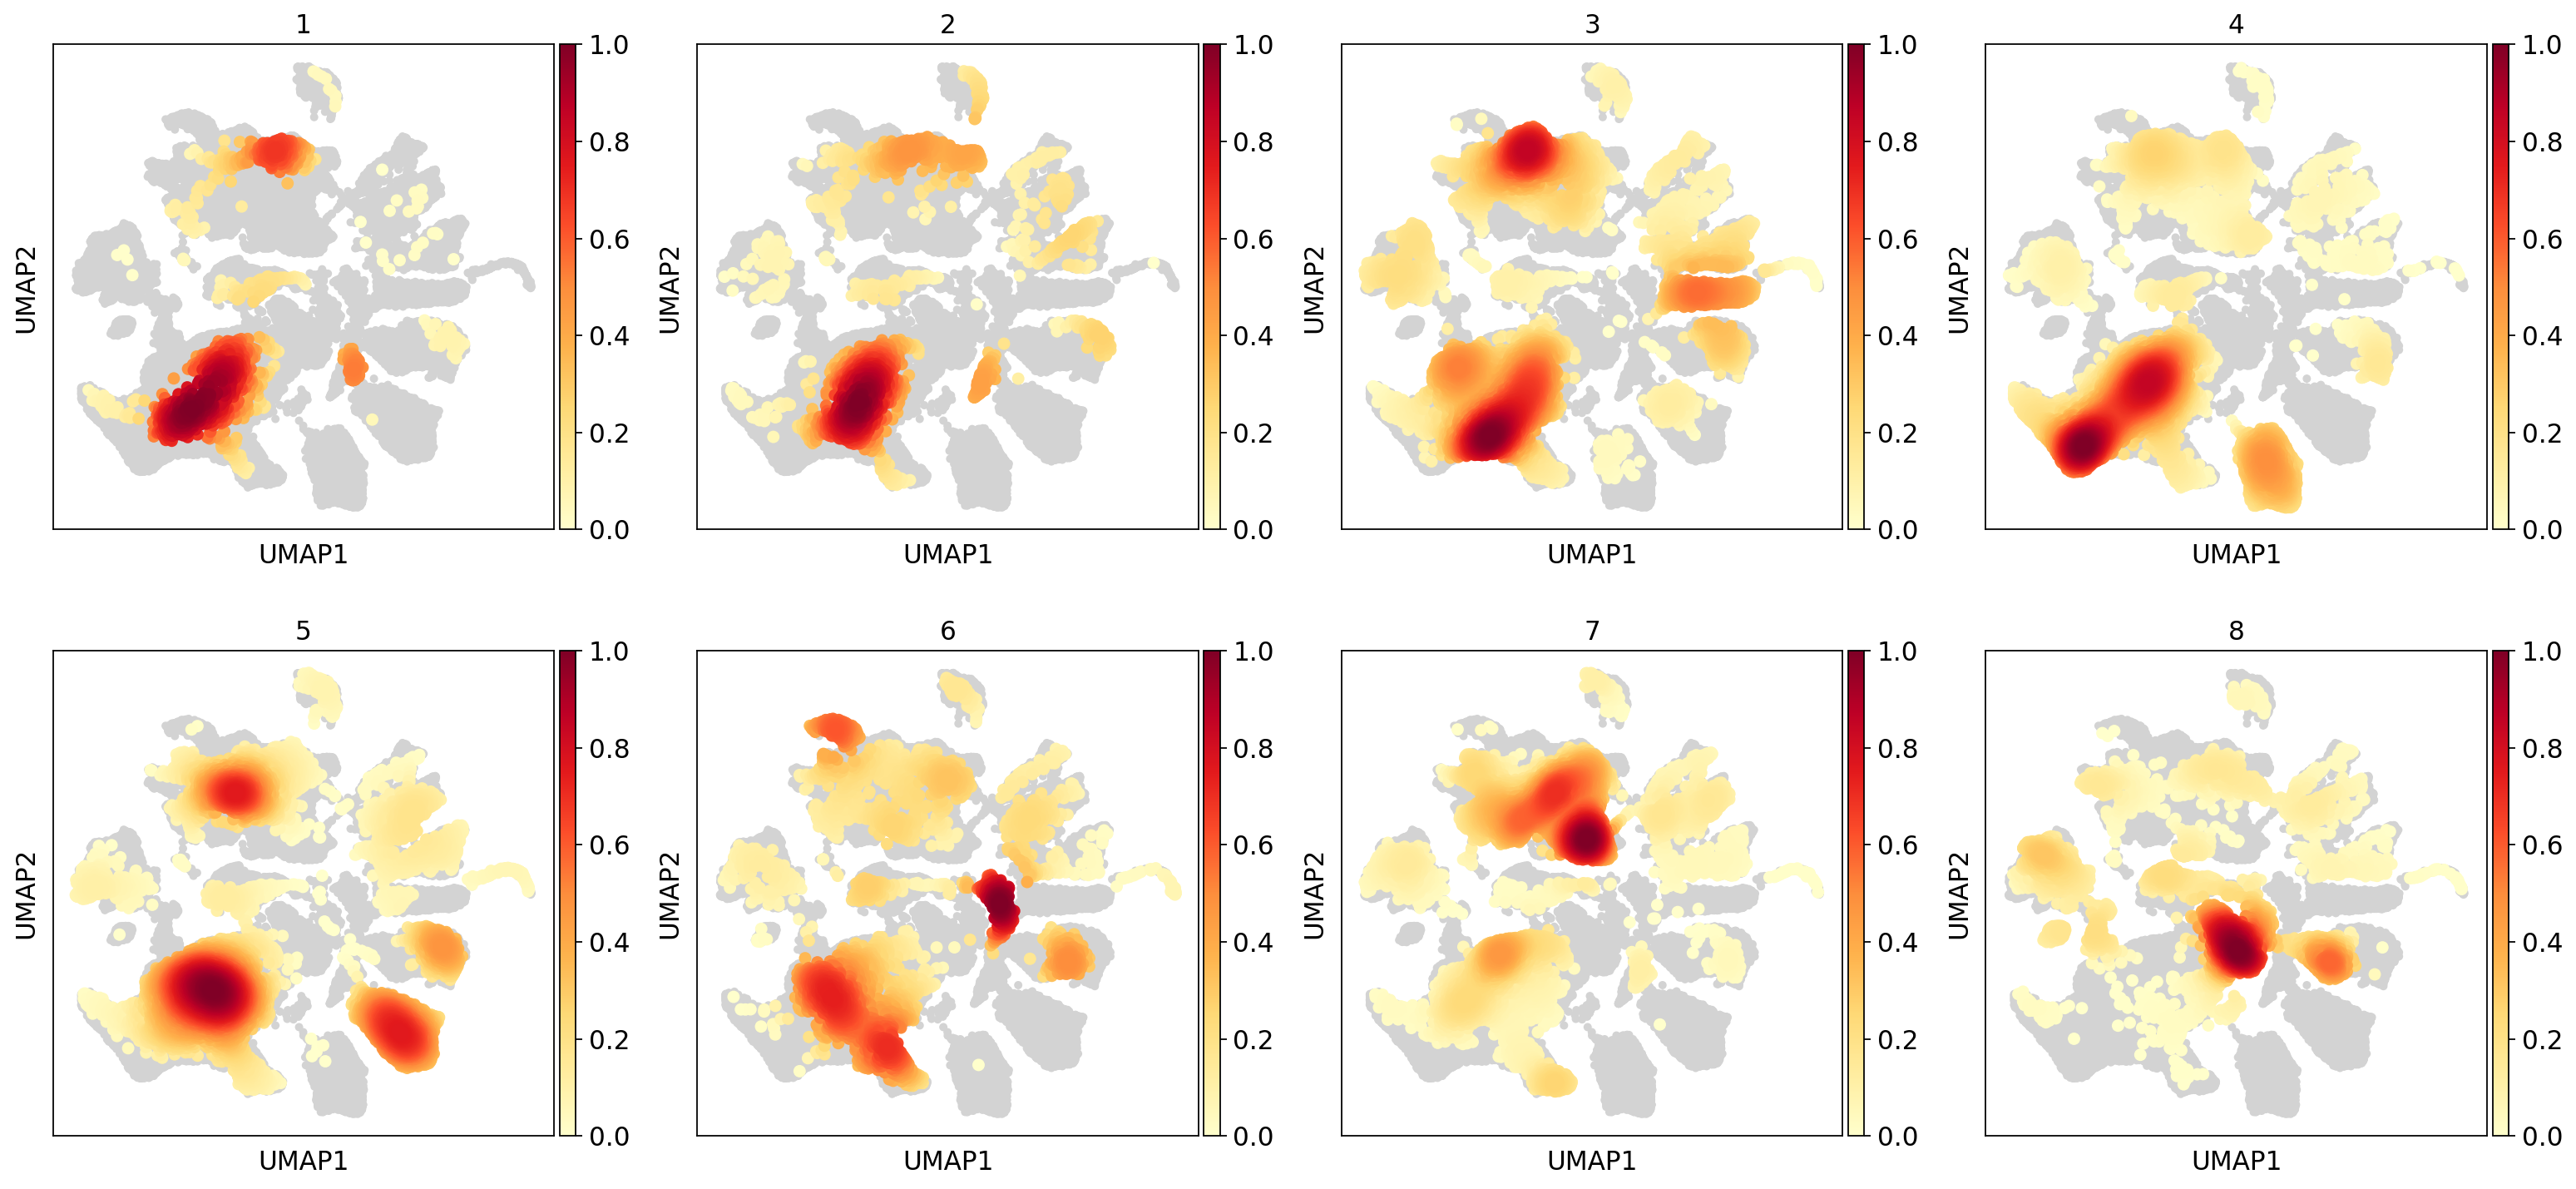

In [36]:
sc.pl.embedding_density(adata, groupby="PatientNumber")

### TSNE + K-means
You might want to skip this step. Calucating a TSNE for 90000 cells takes really long 

In [37]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=8, random_state=0).fit(adata.obsm['X_pca'])
adata.obs['kmeans'] = kmeans.labels_.astype(str)

/home/sedi10/conda/envs/rapids-22.12/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [38]:
%%time
sc.tl.tsne(adata, n_pcs = 40)

/home/sedi10/conda/envs/rapids-22.12/lib/python3.9/site-packages/scanpy/tools/_tsne.py:113: UserWarning: In previous versions of scanpy, calling tsne with n_jobs > 1 would use MulticoreTSNE. Now this uses the scikit-learn version of TSNE by default. If you'd like the old behaviour (which is deprecated), pass 'use_fast_tsne=True'. Note, MulticoreTSNE is not actually faster anymore.
  warnings.warn(


CPU times: user 2h 33min 54s, sys: 1min 3s, total: 2h 34min 58s
Wall time: 3min 18s


/home/sedi10/conda/envs/rapids-22.12/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


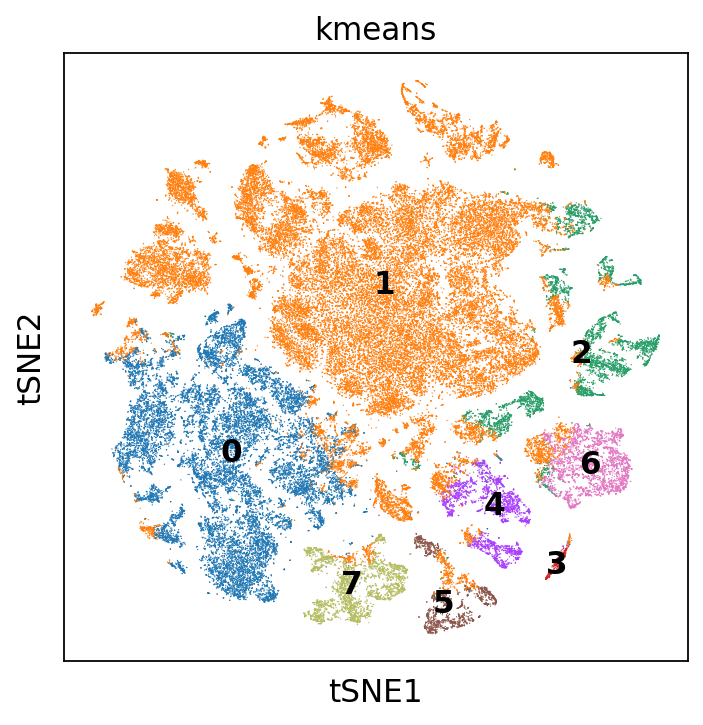

In [39]:
sc.pl.tsne(adata,color=["kmeans"], legend_loc='on data')

/home/sedi10/conda/envs/rapids-22.12/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/sedi10/conda/envs/rapids-22.12/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


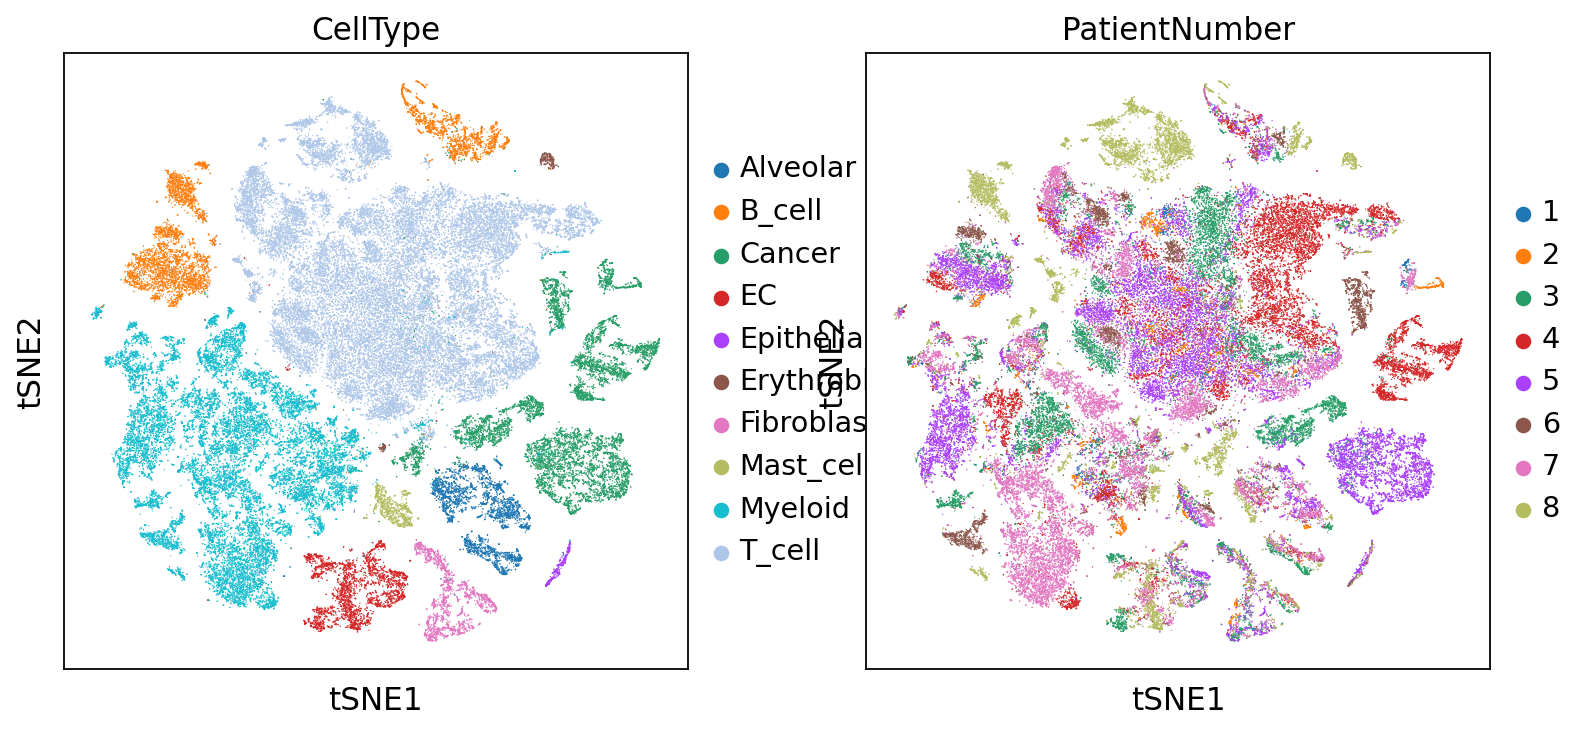

CPU times: user 1.02 s, sys: 192 ms, total: 1.21 s
Wall time: 1.03 s


In [40]:
%%time
sc.pl.tsne(adata, color= ["CellType", "PatientNumber"])

## Differential expression analysis

We now use logistic regression to compute a ranking for highly differential genes in each Louvain cluster.

In [41]:
%%time
sc.tl.rank_genes_groups(adata, 'CellType', method='logreg', use_raw=False)

CPU times: user 57min 16s, sys: 48min 12s, total: 1h 45min 28s
Wall time: 1min 33s


/home/sedi10/conda/envs/rapids-22.12/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


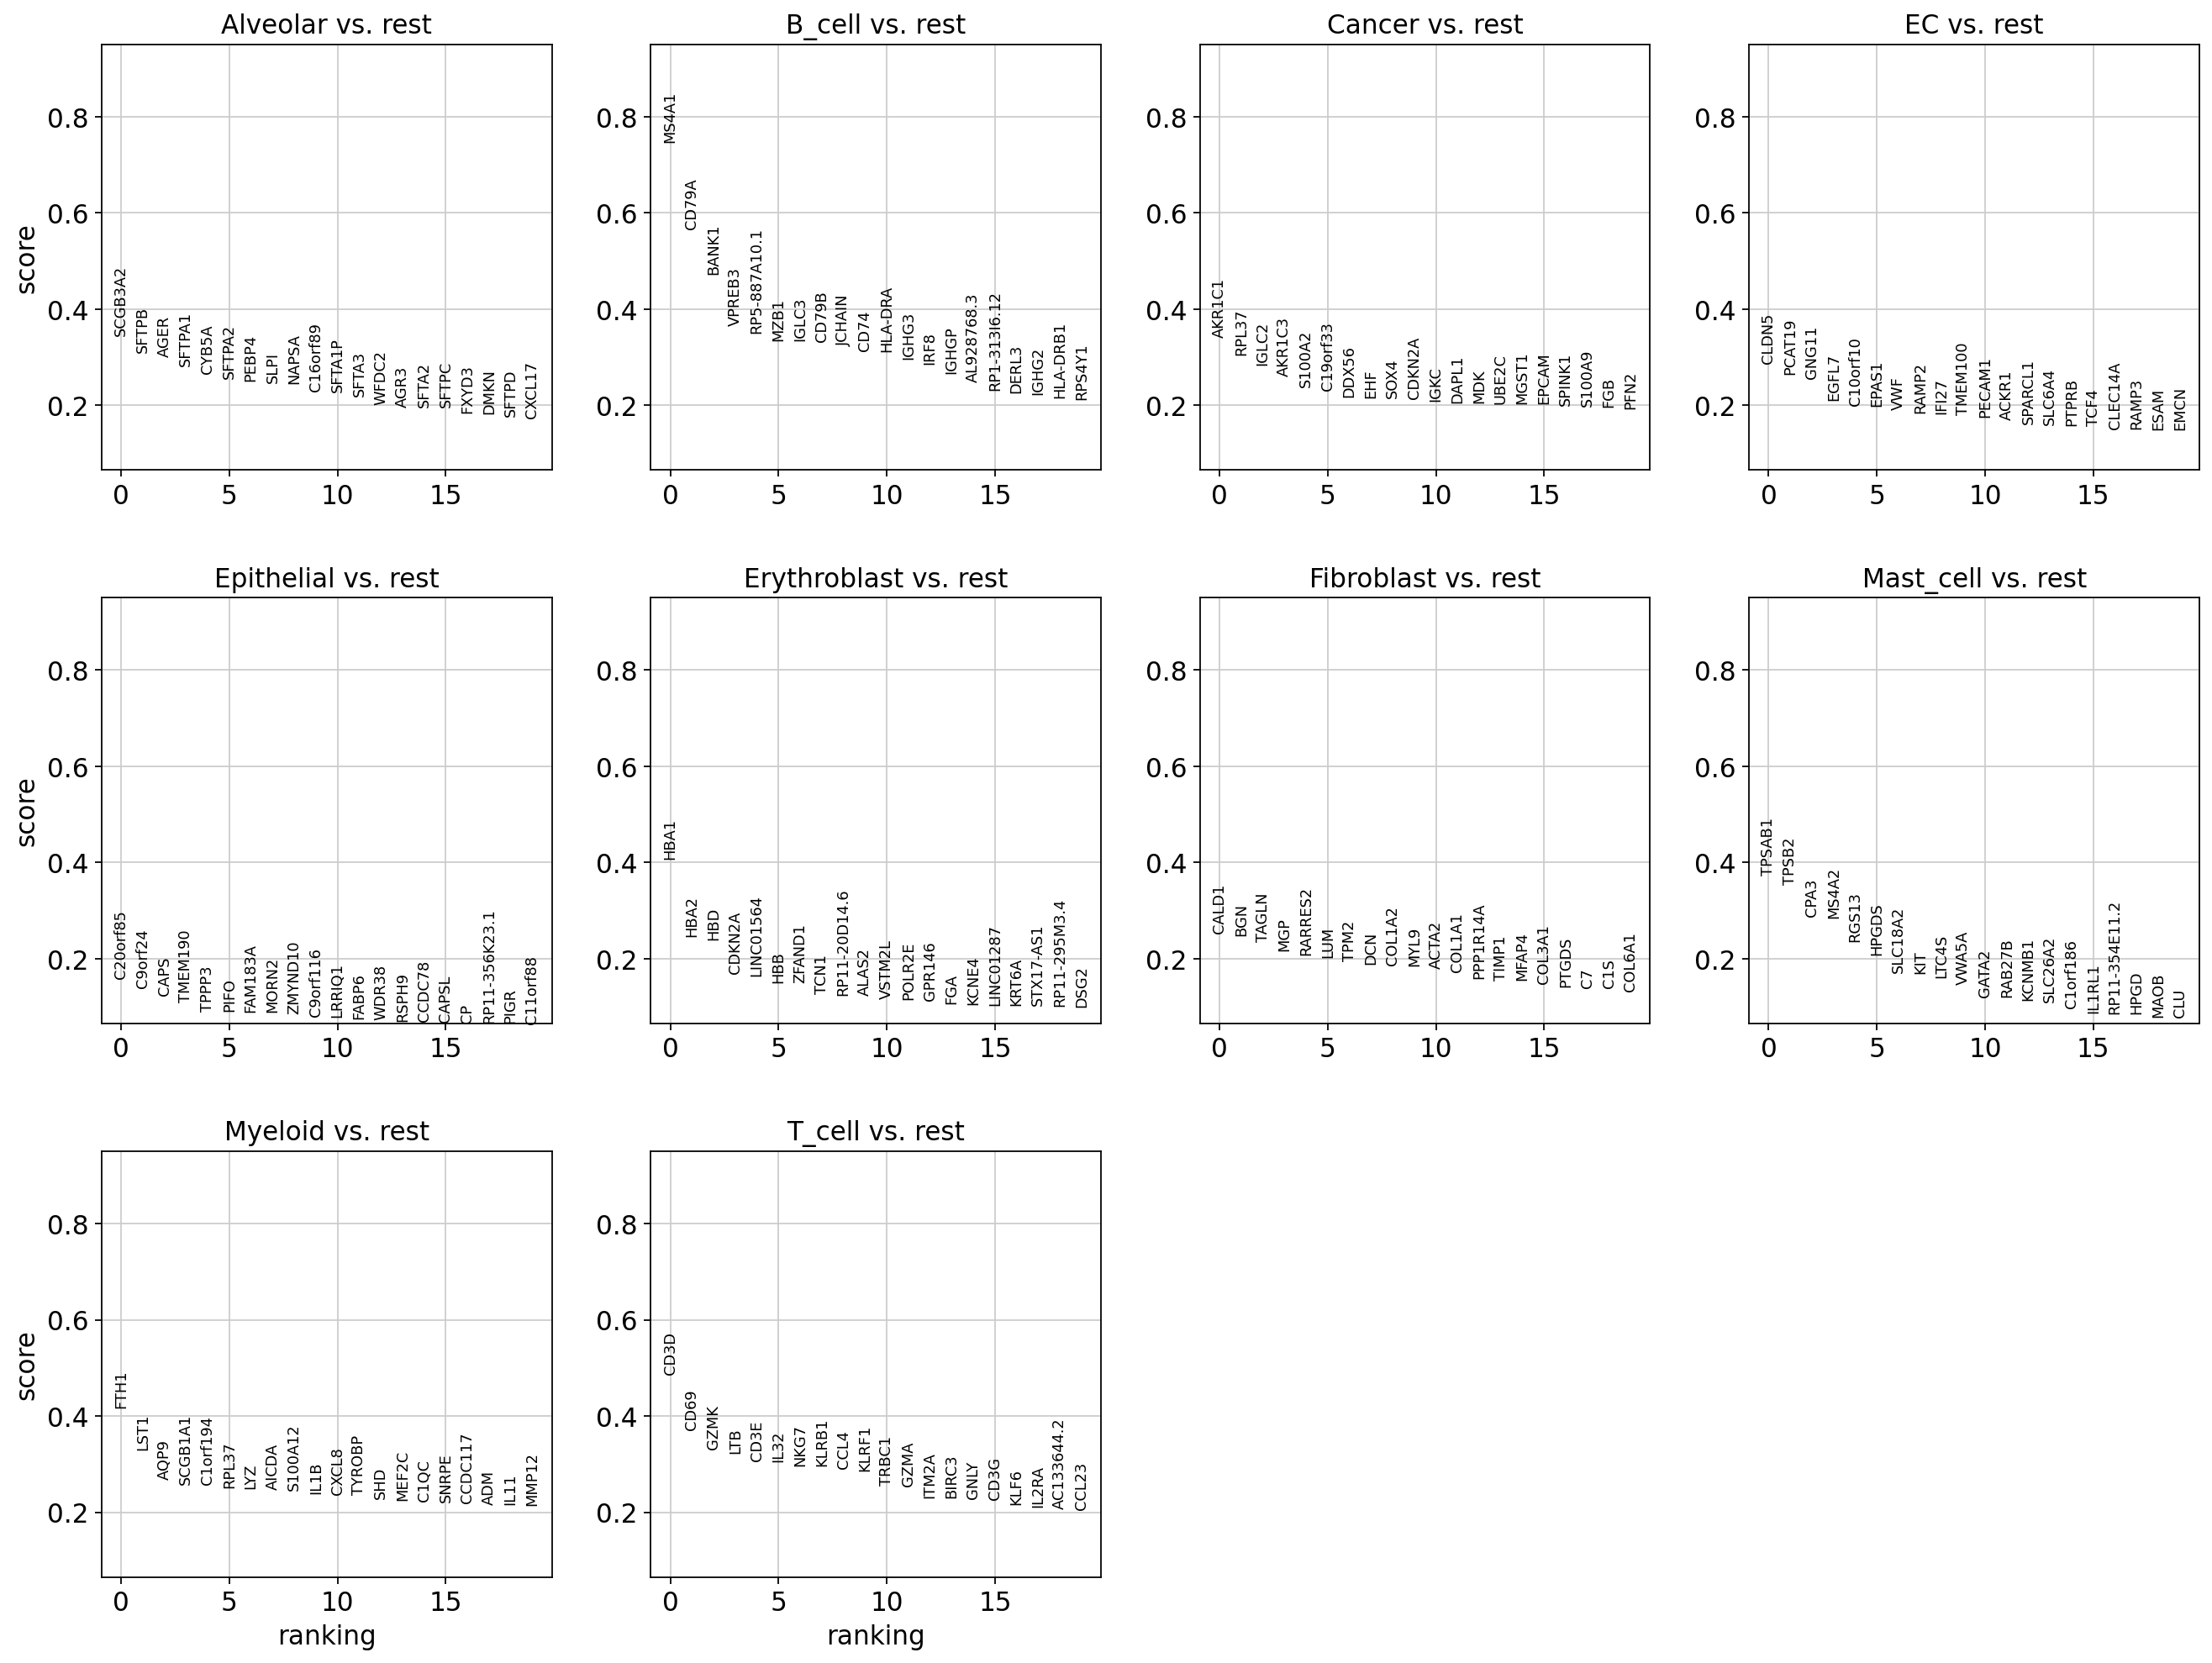

CPU times: user 924 ms, sys: 172 ms, total: 1.1 s
Wall time: 920 ms


In [42]:
%%time
sc.pl.rank_genes_groups(adata, n_genes=20)

In [43]:
post_time = time.time()

In [44]:
print("Total Postprocessing time: %s" % (post_time-preprocess_time))

Total Postprocessing time: 791.8698892593384


## Diffusion Maps

We now create a Diffusion Map of the T-Cells to look at trajectories.

First we create a subset of only the T-Cells

In [45]:
tdata = adata[adata.obs["CellType"] == 'T_cell',:]

We can repeat the dimension reduction, clustering and visulatization.

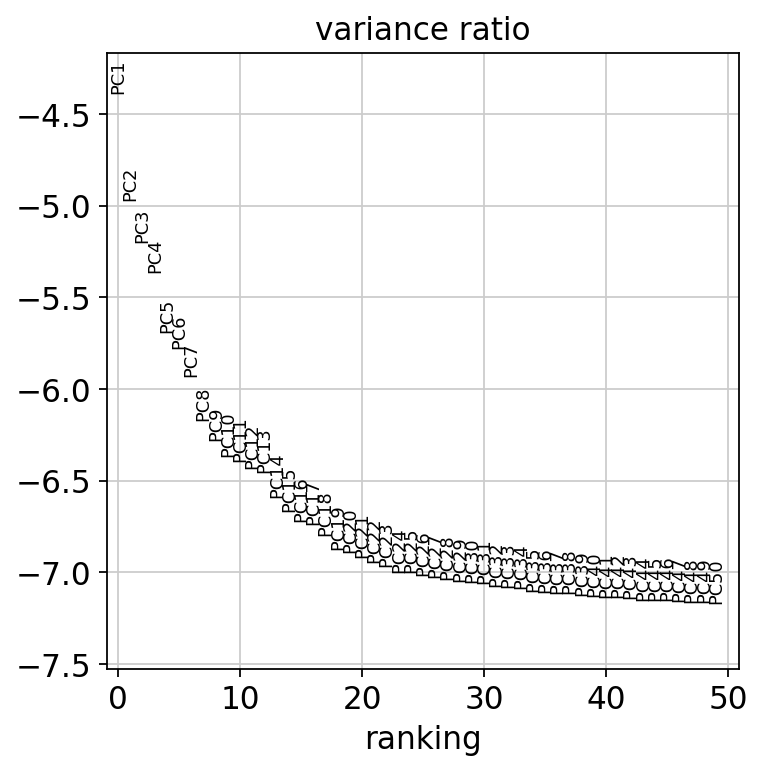

CPU times: user 28min 52s, sys: 44min 15s, total: 1h 13min 7s
Wall time: 44.5 s


In [46]:
%%time
sc.pp.pca(tdata,n_comps=50)
sc.pl.pca_variance_ratio(tdata, log=True,n_pcs=50)

In [47]:
%%time
sc.pp.neighbors(tdata, n_neighbors=15, n_pcs=20)
sc.tl.umap(tdata)
sc.tl.louvain(tdata)

CPU times: user 1min 7s, sys: 2min 30s, total: 3min 37s
Wall time: 27.8 s


/home/sedi10/conda/envs/rapids-22.12/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


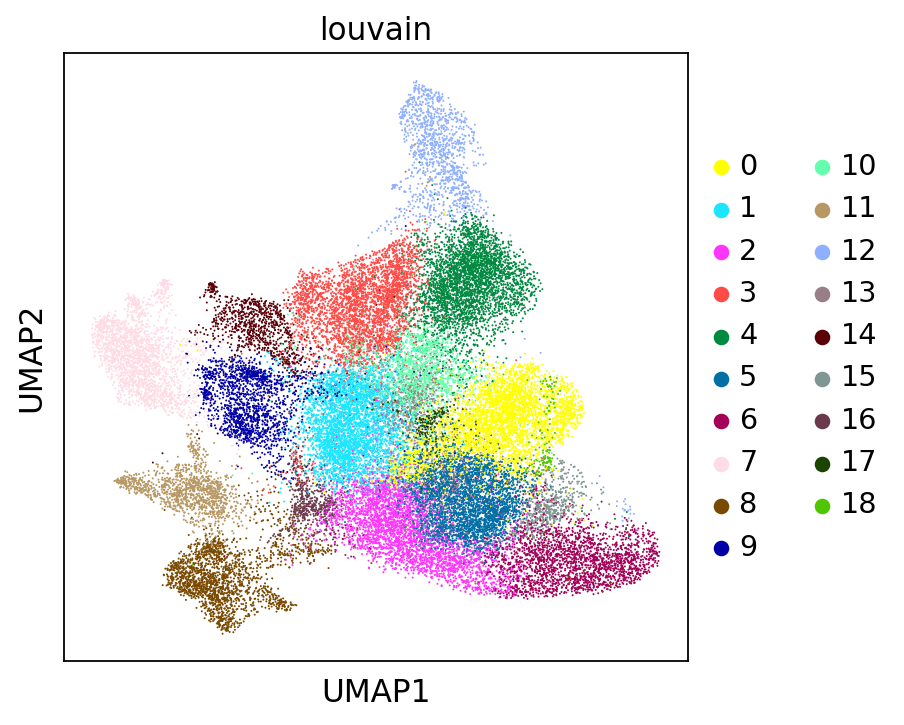

In [48]:
sc.pl.umap(tdata, color=["louvain"])

In [49]:
%%time
sc.tl.diffmap(tdata)

CPU times: user 26.4 s, sys: 1min 42s, total: 2min 9s
Wall time: 1.37 s


/home/sedi10/conda/envs/rapids-22.12/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


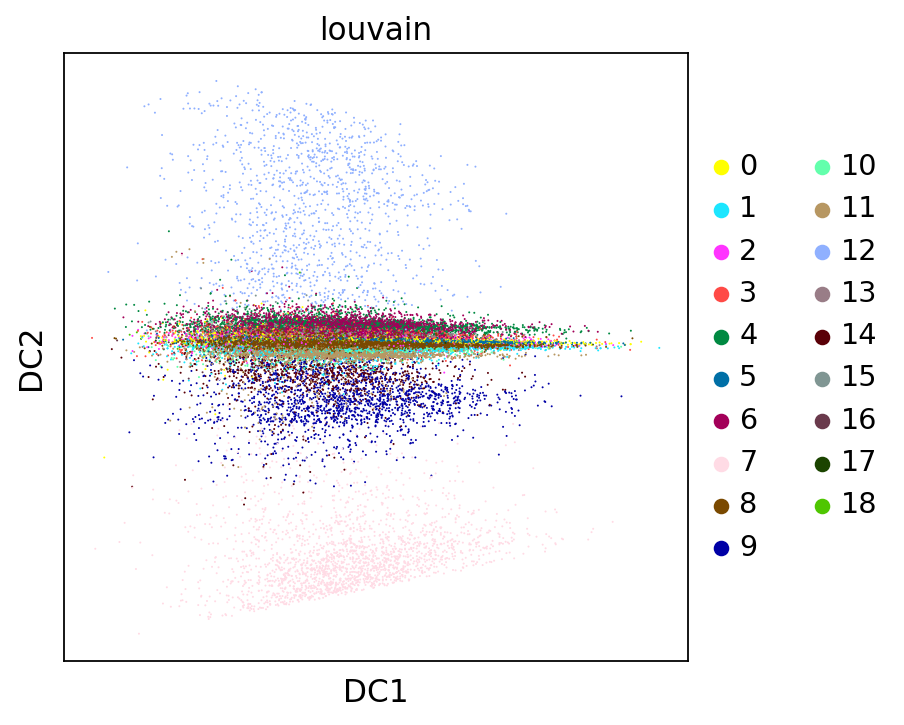

In [50]:
sc.pl.diffmap(tdata, color='louvain')

In [51]:
%%time
sc.tl.draw_graph(tdata)

CPU times: user 5min 2s, sys: 553 ms, total: 5min 3s
Wall time: 5min 4s


/home/sedi10/conda/envs/rapids-22.12/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


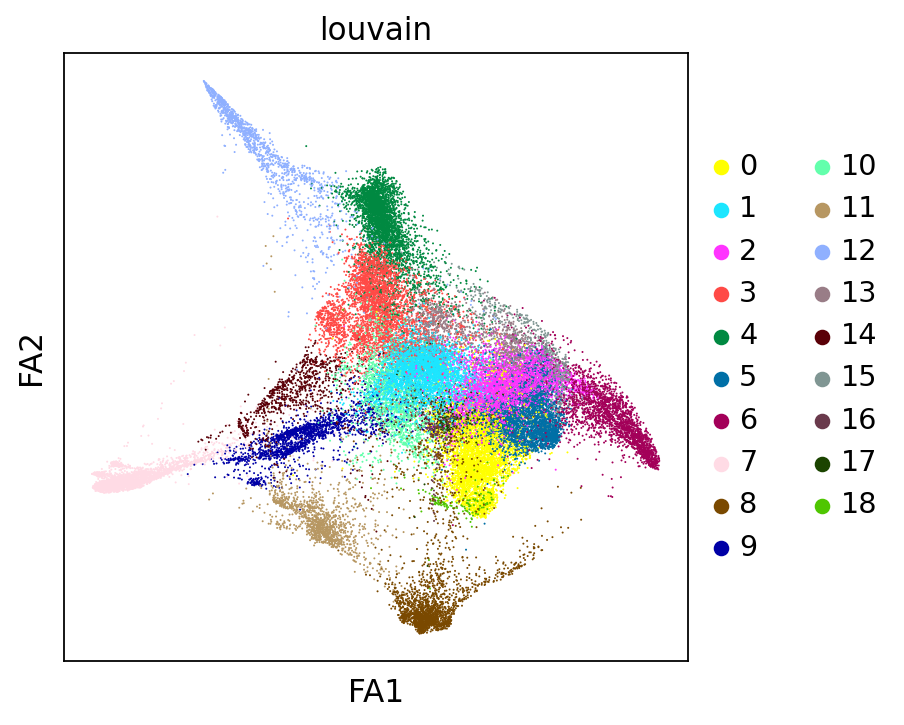

In [52]:
sc.pl.draw_graph(tdata, color='louvain')

In [53]:
print("Total Preprocessing time: %s" % (time.time()-preprocess_start))

Total Preprocessing time: 1529.0898954868317
